# Plan and Execute Agent

Based on [Langgraph's Plan-and-Execute documentation](https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/)

In [16]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun

from langgraph.prebuilt import create_react_agent

from dotenv import load_dotenv

load_dotenv()

import warnings
warnings.filterwarnings('ignore')

### Define Tools

In [6]:
tools = [DuckDuckGoSearchRun()]

### Define Execution Agent

In [18]:
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

llm = ChatOpenAI(name="gpt-4o-mini", temperature=0)
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


### Define State

In [8]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Planning Step

In [9]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [10]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

### Re-Plan Step

In [11]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """
    **Objective**:
    {input}

    **Original Plan**:
    {plan}

    **Completed Steps**:
    {past_steps}

    **Instructions**:
    - If there are more steps needed to achieve the objective, return a **Plan** with the remaining steps.
    - If all necessary steps have been completed, return a **Response** to the user based on the information gathered.
    - Do **not** include any steps that have already been completed in the new plan.
    - Do **not** return an empty plan; if no further steps are needed, you **must** return a **Response**.
    - Ensure your output is in the correct structured format as per the `Act` model.

    **Remember**:
    - The `Act` can be either a `Plan` or a `Response`.
    - A `Plan` contains a list of steps that still need to be done.
    - A `Response` contains the final answer to the user.

    **Provide your output below:**
    """
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)

### Create Graph

In [12]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [13]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

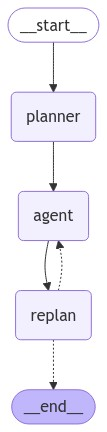

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Test Agent

In [17]:
config = {"recursion_limit": 50}
inputs = {"input": "what is population of the hometown of the wife of the mens 2020 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the 2020 Australian Open men's singles.", "Find out the name of the winner's wife.", "Determine the hometown of the winner's wife.", 'Look up the population of that hometown.']}
{'past_steps': [("Identify the winner of the 2020 Australian Open men's singles.", "The winner of the 2020 Australian Open men's singles was Novak Djokovic.")]}
{'plan': ["Find out the name of Novak Djokovic's wife.", "Determine the hometown of Novak Djokovic's wife.", 'Look up the population of that hometown.']}
{'past_steps': [("Find out the name of Novak Djokovic's wife.", "Novak Djokovic's wife is Jelena Djokovic (née Ristic).")]}
{'plan': ['Determine the hometown of Jelena Djokovic.', 'Look up the population of that hometown.']}
{'past_steps': [('Determine the hometown of Jelena Djokovic.', "Jelena Djokovic's hometown is Belgrade, Serbia.")]}
{'plan': ['Look up the population of Belgrade, Serbia.']}
{'past_steps': [('Look up the population of Belgrade, Serbia.', 'The popul